In [ ]:
!pip install --upgrade progressbar2

  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

In [ ]:
SUM = lambda x,y : x+y

In [ ]:
def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

In [ ]:
def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        #self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        #self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [ ]:
class Classifier(nn.Module):

    def __init__(self,num_classes=10):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

In [ ]:
class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))


In [ ]:
DO='TRAIN'

random.seed(47)

combo_fn = SUM

lambda_reg = 1

In [ ]:
def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        #pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1
        _,pred_label = torch.max(pred, dim = 1)
        pred_labels = (pred_label == labels).float()

        batch_accuracy = pred_labels.sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
      return epoch_accuracy
      #print(f"Accuracy test: {epoch_accuracy:0.5}")

In [ ]:
def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="federated_mnist"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0
      # Store best accuracy to save the model
      best_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.long().to(dev)
            labels_b = labels_b.long().to(dev)

            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])


            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            #pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1

            #print(pred_a.shape)

            _,pred_label_a = torch.max(pred_a, dim = 1)
            pred_labels_a = (pred_label_a == labels_a).float()

            _,pred_label_b = torch.max(pred_b, dim = 1)
            pred_labels_b = (pred_label_b == labels_b).float()

            _,pred_label_c = torch.max(pred_c, dim = 1)
            pred_labels_c = (pred_label_c == labels).float()

            batch_accuracy_a = pred_labels_a.sum().item() / len(labels_a)
            batch_accuracy_b = pred_labels_b.sum().item() / len(labels_b)
            batch_accuracy_c = pred_labels_c.sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}


        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')

        
        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


        # Store params at the best validation accuracy
        if save_param and accuracy_star > best_accuracy:
        # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
          torch.save({'vgg_a':nets[0].state_dict(),'classifier':nets[3].state_dict()}, f"{model_name}_best_test.pth")
          best_accuracy = accuracy_star
        print(f"Best accuracy test is: {best_accuracy:0.5}")


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()

MNIST

In [ ]:
root_dir = './'

rescale_data = transforms.Lambda(lambda x : x/255)

In [ ]:
# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((-0.7376), (0.5795))
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((0.1327), (0.2919))
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")
print(f"{len(test_set)} samples used as test set")

val_set_a = Subset(train_set, val_idx)
train_set_a = Subset(train_set, train_idx)
test_set_a = test_set

Num. training samples: 60000
Num. test samples:     10000
54000 samples used as train set
6000  samples used as val set
10000 samples used as test set


MNIST PERTURBATO

In [ ]:
root_dir = './'

rescale_data = transforms.Lambda(lambda x : x/255)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  AddGaussianNoise(0., 0.2),
  rescale_data,
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  AddGaussianNoise(0., 0.2),
  rescale_data,
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

In [ ]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")
print(f"{len(test_set)} samples used as test set")

val_set_b = Subset(train_set, val_idx)
train_set_b = Subset(train_set, train_idx)
test_set_b = test_set

Num. training samples: 60000
Num. test samples:     10000
54000 samples used as train set
6000  samples used as val set
10000 samples used as test set


In [ ]:
test_set = torch.utils.data.ConcatDataset([test_set_a, test_set_b])

# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=128, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}

Label: 5


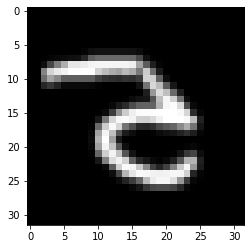

In [ ]:
image, label = train_set_a[1]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

Label: 7


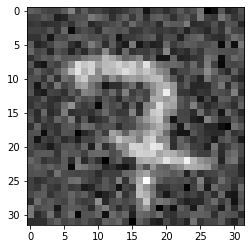

In [ ]:
image, label = train_set_b[7]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [ ]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
classifier = Classifier(num_classes=10)

In [ ]:
nets = [model1,model2,model3,classifier]

dev = torch.device('cuda')

parameters = set()

for n in nets:
  parameters |= set(n.parameters())

optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
#criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
criterion = nn.CrossEntropyLoss()
n_params = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:   0.18]


Epoch 1:
	train	Loss: 6.9793	VGG 1:0.14287	VGG 2:0.16692	VGG *:0.13386
	val	Loss: 6.4735	VGG 1:0.2685	VGG 2:0.42299	VGG *:0.11302
	test	Loss: 6.4552	VGG 1:0.26335	VGG 2:0.43938	VGG *:0.11412
Accuracy test VGGA: 0.26269
Accuracy test VGGB: 0.44686
Accuracy test VGG*: 0.114
Accuracy test VGGSTAR: 0.2196
Best accuracy test is: 0.2196


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.309]


Epoch 2:
	train	Loss: 5.7392	VGG 1:0.2659	VGG 2:0.43867	VGG *:0.22778
	val	Loss: 4.3738	VGG 1:0.4191	VGG 2:0.7292	VGG *:0.34959
	test	Loss: 4.3149	VGG 1:0.42939	VGG 2:0.75257	VGG *:0.34568
Accuracy test VGGA: 0.42765
Accuracy test VGGB: 0.75717
Accuracy test VGG*: 0.34733
Accuracy test VGGSTAR: 0.11679
Best accuracy test is: 0.2196


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.762]


Epoch 3:
	train	Loss: 3.2282	VGG 1:0.66312	VGG 2:0.63862	VGG *:0.57132
	val	Loss: 1.53	VGG 1:0.81889	VGG 2:0.8522	VGG *:0.8315
	test	Loss: 1.4731	VGG 1:0.82575	VGG 2:0.86135	VGG *:0.83846
Accuracy test VGGA: 0.81718
Accuracy test VGGB: 0.8647
Accuracy test VGG*: 0.83867
Accuracy test VGGSTAR: 0.32713
Best accuracy test is: 0.32713


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.832]


Epoch 4:
	train	Loss: 1.9837	VGG 1:0.72909	VGG 2:0.8658	VGG *:0.74565
	val	Loss: 1.1998	VGG 1:0.80419	VGG 2:0.91425	VGG *:0.89327
	test	Loss: 1.1437	VGG 1:0.81042	VGG 2:0.91822	VGG *:0.89453
Accuracy test VGGA: 0.80474
Accuracy test VGGB: 0.92377
Accuracy test VGG*: 0.89515
Accuracy test VGGSTAR: 0.72407
Best accuracy test is: 0.72407


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.934]


Epoch 5:
	train	Loss: 1.1563	VGG 1:0.86214	VGG 2:0.9205	VGG *:0.83908
	val	Loss: 0.68213	VGG 1:0.92152	VGG 2:0.93987	VGG *:0.91901
	test	Loss: 0.65082	VGG 1:0.9283	VGG 2:0.93958	VGG *:0.92262
Accuracy test VGGA: 0.92038
Accuracy test VGGB: 0.93934
Accuracy test VGG*: 0.92272
Accuracy test VGGSTAR: 0.65137
Best accuracy test is: 0.72407


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.957]


Epoch 6:
	train	Loss: 0.91372	VGG 1:0.89816	VGG 2:0.93581	VGG *:0.87263
	val	Loss: 0.53533	VGG 1:0.9389	VGG 2:0.9583	VGG *:0.93524
	test	Loss: 0.49776	VGG 1:0.94284	VGG 2:0.96015	VGG *:0.93646
Accuracy test VGGA: 0.93655
Accuracy test VGGB: 0.96427
Accuracy test VGG*: 0.9381
Accuracy test VGGSTAR: 0.73816
Best accuracy test is: 0.73816


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.957]


Epoch 7:
	train	Loss: 0.62337	VGG 1:0.93782	VGG 2:0.95316	VGG *:0.91009
	val	Loss: 0.44308	VGG 1:0.95612	VGG 2:0.95381	VGG *:0.95092
	test	Loss: 0.41057	VGG 1:0.95767	VGG 2:0.95688	VGG *:0.95125
Accuracy test VGGA: 0.9475
Accuracy test VGGB: 0.95964
Accuracy test VGG*: 0.95079
Accuracy test VGGSTAR: 0.80459
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.945]


Epoch 8:
	train	Loss: 0.69289	VGG 1:0.94914	VGG 2:0.90703	VGG *:0.92456
	val	Loss: 0.44977	VGG 1:0.95331	VGG 2:0.95823	VGG *:0.94794
	test	Loss: 0.40411	VGG 1:0.95936	VGG 2:0.96499	VGG *:0.95194
Accuracy test VGGA: 0.95004
Accuracy test VGGB: 0.96686
Accuracy test VGG*: 0.95228
Accuracy test VGGSTAR: 0.66874
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.941]


Epoch 9:
	train	Loss: 0.50658	VGG 1:0.95836	VGG 2:0.95864	VGG *:0.92169
	val	Loss: 0.37367	VGG 1:0.95664	VGG 2:0.96578	VGG *:0.95314
	test	Loss: 0.34571	VGG 1:0.96074	VGG 2:0.96915	VGG *:0.95525
Accuracy test VGGA: 0.95298
Accuracy test VGGB: 0.97064
Accuracy test VGG*: 0.95417
Accuracy test VGGSTAR: 0.70317
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.945]


Epoch 10:
	train	Loss: 0.43937	VGG 1:0.96478	VGG 2:0.96636	VGG *:0.93106
	val	Loss: 0.31855	VGG 1:0.96861	VGG 2:0.97162	VGG *:0.9583
	test	Loss: 0.30409	VGG 1:0.97142	VGG 2:0.97241	VGG *:0.95713
Accuracy test VGGA: 0.96432
Accuracy test VGGB: 0.97457
Accuracy test VGG*: 0.95755
Accuracy test VGGSTAR: 0.71855
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.965]


Epoch 11:
	train	Loss: 0.42764	VGG 1:0.9694	VGG 2:0.97068	VGG *:0.92531
	val	Loss: 0.29304	VGG 1:0.96884	VGG 2:0.97801	VGG *:0.96261
	test	Loss: 0.26021	VGG 1:0.97419	VGG 2:0.97696	VGG *:0.96618
Accuracy test VGGA: 0.96726
Accuracy test VGGB: 0.97845
Accuracy test VGG*: 0.96427
Accuracy test VGGSTAR: 0.40336
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.984]


Epoch 12:
	train	Loss: 0.37063	VGG 1:0.97192	VGG 2:0.97439	VGG *:0.93602
	val	Loss: 0.28087	VGG 1:0.9696	VGG 2:0.97749	VGG *:0.96557
	test	Loss: 0.24712	VGG 1:0.97696	VGG 2:0.97765	VGG *:0.96563
Accuracy test VGGA: 0.96661
Accuracy test VGGB: 0.9797
Accuracy test VGG*: 0.96497
Accuracy test VGGSTAR: 0.77642
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.965]


Epoch 13:
	train	Loss: 0.4801	VGG 1:0.97272	VGG 2:0.97673	VGG *:0.90927
	val	Loss: 0.30373	VGG 1:0.9693	VGG 2:0.97818	VGG *:0.96274
	test	Loss: 0.27395	VGG 1:0.9733	VGG 2:0.98121	VGG *:0.96484
Accuracy test VGGA: 0.96422
Accuracy test VGGB: 0.98144
Accuracy test VGG*: 0.96532
Accuracy test VGGSTAR: 0.51279
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.949]


Epoch 14:
	train	Loss: 0.3433	VGG 1:0.97489	VGG 2:0.97942	VGG *:0.93788
	val	Loss: 0.26936	VGG 1:0.96998	VGG 2:0.98001	VGG *:0.96716
	test	Loss: 0.25912	VGG 1:0.96924	VGG 2:0.98022	VGG *:0.96494
Accuracy test VGGA: 0.95815
Accuracy test VGGB: 0.98109
Accuracy test VGG*: 0.96542
Accuracy test VGGSTAR: 0.59101
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.949]


Epoch 15:
	train	Loss: 0.88751	VGG 1:0.97699	VGG 2:0.91887	VGG *:0.81301
	val	Loss: 0.30999	VGG 1:0.97215	VGG 2:0.97336	VGG *:0.96458
	test	Loss: 0.29405	VGG 1:0.97903	VGG 2:0.97004	VGG *:0.9643
Accuracy test VGGA: 0.97233
Accuracy test VGGB: 0.97218
Accuracy test VGG*: 0.96517
Accuracy test VGGSTAR: 0.71193
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.953]


Epoch 16:
	train	Loss: 0.37577	VGG 1:0.97853	VGG 2:0.97293	VGG *:0.92651
	val	Loss: 0.25576	VGG 1:0.97606	VGG 2:0.97585	VGG *:0.96769
	test	Loss: 0.22981	VGG 1:0.97943	VGG 2:0.97706	VGG *:0.97048
Accuracy test VGGA: 0.96979
Accuracy test VGGB: 0.97781
Accuracy test VGG*: 0.96905
Accuracy test VGGSTAR: 0.69238
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:51] |###############| [Time:  0:01:51] [Train Acc:  0.969]


Epoch 17:
	train	Loss: 0.32656	VGG 1:0.98072	VGG 2:0.97916	VGG *:0.93593
	val	Loss: 0.24468	VGG 1:0.9739	VGG 2:0.97863	VGG *:0.97008
	test	Loss: 0.21277	VGG 1:0.98032	VGG 2:0.97923	VGG *:0.97038
Accuracy test VGGA: 0.97323
Accuracy test VGGB: 0.98094
Accuracy test VGG*: 0.97014
Accuracy test VGGSTAR: 0.59768
Best accuracy test is: 0.80459


 [Elapsed Time: 0:01:51] |###############| [Time:  0:01:51] [Train Acc:  0.984]


Epoch 18:
	train	Loss: 0.42784	VGG 1:0.9818	VGG 2:0.98154	VGG *:0.907
	val	Loss: 0.2553	VGG 1:0.97642	VGG 2:0.97799	VGG *:0.97057
	test	Loss: 0.23411	VGG 1:0.98131	VGG 2:0.98022	VGG *:0.96944
Accuracy test VGGA: 0.97278
Accuracy test VGGB: 0.98273
Accuracy test VGG*: 0.9684
Accuracy test VGGSTAR: 0.81663
Best accuracy test is: 0.81663


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.977]


Epoch 19:
	train	Loss: 0.25121	VGG 1:0.98178	VGG 2:0.98369	VGG *:0.95418
	val	Loss: 0.20534	VGG 1:0.98096	VGG 2:0.98084	VGG *:0.9739
	test	Loss: 0.18568	VGG 1:0.98319	VGG 2:0.9825	VGG *:0.97434
Accuracy test VGGA: 0.97631
Accuracy test VGGB: 0.98298
Accuracy test VGG*: 0.97363
Accuracy test VGGSTAR: 0.7714
Best accuracy test is: 0.81663


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.973]


Epoch 20:
	train	Loss: 0.23194	VGG 1:0.98436	VGG 2:0.98478	VGG *:0.9576
	val	Loss: 0.20175	VGG 1:0.9786	VGG 2:0.9835	VGG *:0.97513
	test	Loss: 0.20315	VGG 1:0.98072	VGG 2:0.98279	VGG *:0.97043
Accuracy test VGGA: 0.9697
Accuracy test VGGB: 0.98368
Accuracy test VGG*: 0.97009
Accuracy test VGGSTAR: 0.79857
Best accuracy test is: 0.81663


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 21:
	train	Loss: 0.23055	VGG 1:0.98595	VGG 2:0.98523	VGG *:0.95871
	val	Loss: 0.19336	VGG 1:0.98096	VGG 2:0.9867	VGG *:0.97592
	test	Loss: 0.17412	VGG 1:0.98428	VGG 2:0.98635	VGG *:0.97587
Accuracy test VGGA: 0.97676
Accuracy test VGGB: 0.98557
Accuracy test VGG*: 0.97522
Accuracy test VGGSTAR: 0.80728
Best accuracy test is: 0.81663


 [Elapsed Time: 0:01:54] |###############| [Time:  0:01:54] [Train Acc:  0.961]


Epoch 22:
	train	Loss: 0.25604	VGG 1:0.98738	VGG 2:0.98599	VGG *:0.94566
	val	Loss: 0.19023	VGG 1:0.97993	VGG 2:0.98635	VGG *:0.97505
	test	Loss: 0.1833	VGG 1:0.98358	VGG 2:0.98447	VGG *:0.97246
Accuracy test VGGA: 0.97457
Accuracy test VGGB: 0.98642
Accuracy test VGG*: 0.97268
Accuracy test VGGSTAR: 0.89281
Best accuracy test is: 0.89281


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.941]


Epoch 23:
	train	Loss: 0.24001	VGG 1:0.98697	VGG 2:0.98632	VGG *:0.9508
	val	Loss: 0.19638	VGG 1:0.98176	VGG 2:0.98537	VGG *:0.97206
	test	Loss: 0.19473	VGG 1:0.9823	VGG 2:0.98279	VGG *:0.97142
Accuracy test VGGA: 0.97368
Accuracy test VGGB: 0.98408
Accuracy test VGG*: 0.97119
Accuracy test VGGSTAR: 0.86027
Best accuracy test is: 0.89281


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.984]


Epoch 24:
	train	Loss: 0.23187	VGG 1:0.9882	VGG 2:0.98766	VGG *:0.94995
	val	Loss: 0.18274	VGG 1:0.98245	VGG 2:0.98352	VGG *:0.97972
	test	Loss: 0.16492	VGG 1:0.98358	VGG 2:0.98576	VGG *:0.97725
Accuracy test VGGA: 0.97368
Accuracy test VGGB: 0.98527
Accuracy test VGG*: 0.97646
Accuracy test VGGSTAR: 0.81519
Best accuracy test is: 0.89281


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.957]


Epoch 25:
	train	Loss: 0.25188	VGG 1:0.9889	VGG 2:0.98786	VGG *:0.94388
	val	Loss: 0.20746	VGG 1:0.98041	VGG 2:0.98471	VGG *:0.97147
	test	Loss: 0.18776	VGG 1:0.98329	VGG 2:0.98388	VGG *:0.97325
Accuracy test VGGA: 0.97656
Accuracy test VGGB: 0.98537
Accuracy test VGG*: 0.97348
Accuracy test VGGSTAR: 0.87137
Best accuracy test is: 0.89281


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.961]


Epoch 26:
	train	Loss: 0.19194	VGG 1:0.98946	VGG 2:0.98833	VGG *:0.96081
	val	Loss: 0.22057	VGG 1:0.97832	VGG 2:0.98787	VGG *:0.96516
	test	Loss: 0.20523	VGG 1:0.98111	VGG 2:0.98625	VGG *:0.96652
Accuracy test VGGA: 0.97104
Accuracy test VGGB: 0.98816
Accuracy test VGG*: 0.96571
Accuracy test VGGSTAR: 0.89361
Best accuracy test is: 0.89361


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.984]


Epoch 27:
	train	Loss: 0.17439	VGG 1:0.99102	VGG 2:0.98851	VGG *:0.96482
	val	Loss: 0.17959	VGG 1:0.98392	VGG 2:0.98449	VGG *:0.97857
	test	Loss: 0.16205	VGG 1:0.98566	VGG 2:0.9823	VGG *:0.97859
Accuracy test VGGA: 0.97811
Accuracy test VGGB: 0.98512
Accuracy test VGG*: 0.97716
Accuracy test VGGSTAR: 0.88918
Best accuracy test is: 0.89361


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 28:
	train	Loss: 0.17414	VGG 1:0.9912	VGG 2:0.9895	VGG *:0.96427
	val	Loss: 0.18196	VGG 1:0.98378	VGG 2:0.98637	VGG *:0.97673
	test	Loss: 0.16487	VGG 1:0.98635	VGG 2:0.98665	VGG *:0.97478
Accuracy test VGGA: 0.9786
Accuracy test VGGB: 0.98671
Accuracy test VGG*: 0.97467
Accuracy test VGGSTAR: 0.91789
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.988]


Epoch 29:
	train	Loss: 0.1764	VGG 1:0.99165	VGG 2:0.99	VGG *:0.96206
	val	Loss: 0.17225	VGG 1:0.9835	VGG 2:0.98549	VGG *:0.97724
	test	Loss: 0.16781	VGG 1:0.98428	VGG 2:0.98408	VGG *:0.97814
Accuracy test VGGA: 0.97661
Accuracy test VGGB: 0.98597
Accuracy test VGG*: 0.97776
Accuracy test VGGSTAR: 0.88545
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 30:
	train	Loss: 0.17056	VGG 1:0.99198	VGG 2:0.99013	VGG *:0.96385
	val	Loss: 0.17319	VGG 1:0.984	VGG 2:0.98551	VGG *:0.97706
	test	Loss: 0.16836	VGG 1:0.98517	VGG 2:0.98497	VGG *:0.97656
Accuracy test VGGA: 0.97716
Accuracy test VGGB: 0.98771
Accuracy test VGG*: 0.97676
Accuracy test VGGSTAR: 0.84574
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.984]


Epoch 31:
	train	Loss: 0.17194	VGG 1:0.9928	VGG 2:0.99057	VGG *:0.96206
	val	Loss: 0.17077	VGG 1:0.98314	VGG 2:0.9877	VGG *:0.97707
	test	Loss: 0.15925	VGG 1:0.98457	VGG 2:0.98705	VGG *:0.97721
Accuracy test VGGA: 0.97592
Accuracy test VGGB: 0.98716
Accuracy test VGG*: 0.97776
Accuracy test VGGSTAR: 0.76752
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 32:
	train	Loss: 0.15923	VGG 1:0.99352	VGG 2:0.99145	VGG *:0.96479
	val	Loss: 0.2046	VGG 1:0.98134	VGG 2:0.98485	VGG *:0.97141
	test	Loss: 0.19733	VGG 1:0.98339	VGG 2:0.98586	VGG *:0.96855
Accuracy test VGGA: 0.97054
Accuracy test VGGB: 0.98711
Accuracy test VGG*: 0.96895
Accuracy test VGGSTAR: 0.77125
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.953]


Epoch 33:
	train	Loss: 0.14755	VGG 1:0.99362	VGG 2:0.99171	VGG *:0.96841
	val	Loss: 0.17127	VGG 1:0.98191	VGG 2:0.98753	VGG *:0.97992
	test	Loss: 0.17507	VGG 1:0.98111	VGG 2:0.98655	VGG *:0.97765
Accuracy test VGGA: 0.97129
Accuracy test VGGB: 0.98756
Accuracy test VGG*: 0.97741
Accuracy test VGGSTAR: 0.7497
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.965]


Epoch 34:
	train	Loss: 0.20734	VGG 1:0.99404	VGG 2:0.9923	VGG *:0.94966
	val	Loss: 0.20451	VGG 1:0.98193	VGG 2:0.98654	VGG *:0.97416
	test	Loss: 0.16849	VGG 1:0.98714	VGG 2:0.98507	VGG *:0.97473
Accuracy test VGGA: 0.98089
Accuracy test VGGB: 0.98761
Accuracy test VGG*: 0.97427
Accuracy test VGGSTAR: 0.79289
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.977]


Epoch 35:
	train	Loss: 0.15311	VGG 1:0.99428	VGG 2:0.99241	VGG *:0.9648
	val	Loss: 0.17624	VGG 1:0.98345	VGG 2:0.98803	VGG *:0.97681
	test	Loss: 0.16356	VGG 1:0.98695	VGG 2:0.98853	VGG *:0.97276
Accuracy test VGGA: 0.9784
Accuracy test VGGB: 0.98855
Accuracy test VGG*: 0.97338
Accuracy test VGGSTAR: 0.73766
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.973]


Epoch 36:
	train	Loss: 0.13186	VGG 1:0.99458	VGG 2:0.99232	VGG *:0.97115
	val	Loss: 0.16949	VGG 1:0.98328	VGG 2:0.98632	VGG *:0.98116
	test	Loss: 0.15006	VGG 1:0.98546	VGG 2:0.98705	VGG *:0.98121
Accuracy test VGGA: 0.98064
Accuracy test VGGB: 0.98841
Accuracy test VGG*: 0.98049
Accuracy test VGGSTAR: 0.84315
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 37:
	train	Loss: 0.13106	VGG 1:0.99484	VGG 2:0.99295	VGG *:0.97066
	val	Loss: 0.153	VGG 1:0.98544	VGG 2:0.98801	VGG *:0.98207
	test	Loss: 0.14575	VGG 1:0.98705	VGG 2:0.98833	VGG *:0.98032
Accuracy test VGGA: 0.98094
Accuracy test VGGB: 0.98851
Accuracy test VGG*: 0.97915
Accuracy test VGGSTAR: 0.81673
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 38:
	train	Loss: 0.15681	VGG 1:0.99536	VGG 2:0.99345	VGG *:0.96238
	val	Loss: 0.17593	VGG 1:0.98492	VGG 2:0.98803	VGG *:0.97615
	test	Loss: 0.16358	VGG 1:0.98774	VGG 2:0.98625	VGG *:0.97701
Accuracy test VGGA: 0.9795
Accuracy test VGGB: 0.98786
Accuracy test VGG*: 0.97606
Accuracy test VGGSTAR: 0.83026
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.984]


Epoch 39:
	train	Loss: 0.11792	VGG 1:0.99521	VGG 2:0.99369	VGG *:0.97319
	val	Loss: 0.15467	VGG 1:0.98663	VGG 2:0.98834	VGG *:0.98098
	test	Loss: 0.1539	VGG 1:0.98655	VGG 2:0.98764	VGG *:0.9779
Accuracy test VGGA: 0.98064
Accuracy test VGGB: 0.98791
Accuracy test VGG*: 0.9785
Accuracy test VGGSTAR: 0.86365
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.984]


Epoch 40:
	train	Loss: 0.12356	VGG 1:0.99625	VGG 2:0.99447	VGG *:0.96995
	val	Loss: 0.15531	VGG 1:0.98661	VGG 2:0.9862	VGG *:0.98073
	test	Loss: 0.14801	VGG 1:0.98596	VGG 2:0.98685	VGG *:0.97973
Accuracy test VGGA: 0.98064
Accuracy test VGGB: 0.98895
Accuracy test VGG*: 0.98024
Accuracy test VGGSTAR: 0.85141
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.984]


Epoch 41:
	train	Loss: 0.11809	VGG 1:0.99607	VGG 2:0.9941	VGG *:0.97251
	val	Loss: 0.16735	VGG 1:0.98475	VGG 2:0.98834	VGG *:0.98053
	test	Loss: 0.14113	VGG 1:0.98942	VGG 2:0.98794	VGG *:0.9819
Accuracy test VGGA: 0.98323
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.98104
Accuracy test VGGSTAR: 0.83972
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.984]


Epoch 42:
	train	Loss: 0.11756	VGG 1:0.99629	VGG 2:0.99326	VGG *:0.97232
	val	Loss: 0.15816	VGG 1:0.9853	VGG 2:0.98801	VGG *:0.98026
	test	Loss: 0.15757	VGG 1:0.98665	VGG 2:0.98635	VGG *:0.97948
Accuracy test VGGA: 0.97855
Accuracy test VGGB: 0.98656
Accuracy test VGG*: 0.9783
Accuracy test VGGSTAR: 0.75552
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.965]


Epoch 43:
	train	Loss: 0.11878	VGG 1:0.99623	VGG 2:0.99432	VGG *:0.97104
	val	Loss: 0.15753	VGG 1:0.98544	VGG 2:0.98969	VGG *:0.98082
	test	Loss: 0.15515	VGG 1:0.98645	VGG 2:0.98902	VGG *:0.97859
Accuracy test VGGA: 0.98194
Accuracy test VGGB: 0.9894
Accuracy test VGG*: 0.97925
Accuracy test VGGSTAR: 0.80011
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.977]


Epoch 44:
	train	Loss: 0.12529	VGG 1:0.99646	VGG 2:0.99354	VGG *:0.9696
	val	Loss: 0.17592	VGG 1:0.9843	VGG 2:0.98483	VGG *:0.98009
	test	Loss: 0.15123	VGG 1:0.98616	VGG 2:0.98853	VGG *:0.97973
Accuracy test VGGA: 0.98049
Accuracy test VGGB: 0.9899
Accuracy test VGG*: 0.98024
Accuracy test VGGSTAR: 0.80135
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.969]


Epoch 45:
	train	Loss: 0.13983	VGG 1:0.99699	VGG 2:0.99415	VGG *:0.96543
	val	Loss: 0.18075	VGG 1:0.98513	VGG 2:0.98654	VGG *:0.97879
	test	Loss: 0.16229	VGG 1:0.98714	VGG 2:0.98447	VGG *:0.97988
Accuracy test VGGA: 0.97955
Accuracy test VGGB: 0.98666
Accuracy test VGG*: 0.97945
Accuracy test VGGSTAR: 0.73293
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.969]


Epoch 46:
	train	Loss: 0.11337	VGG 1:0.99731	VGG 2:0.99456	VGG *:0.97098
	val	Loss: 0.16354	VGG 1:0.98646	VGG 2:0.98765	VGG *:0.97933
	test	Loss: 0.16954	VGG 1:0.98625	VGG 2:0.98566	VGG *:0.9776
Accuracy test VGGA: 0.9788
Accuracy test VGGB: 0.98726
Accuracy test VGG*: 0.97641
Accuracy test VGGSTAR: 0.76289
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.984]


Epoch 47:
	train	Loss: 0.10478	VGG 1:0.99742	VGG 2:0.99482	VGG *:0.9738
	val	Loss: 0.16262	VGG 1:0.9853	VGG 2:0.98801	VGG *:0.98037
	test	Loss: 0.14987	VGG 1:0.98734	VGG 2:0.98774	VGG *:0.97963
Accuracy test VGGA: 0.9797
Accuracy test VGGB: 0.9889
Accuracy test VGG*: 0.9797
Accuracy test VGGSTAR: 0.71382
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:53] |###############| [Time:  0:01:53] [Train Acc:  0.973]


Epoch 48:
	train	Loss: 0.10901	VGG 1:0.99722	VGG 2:0.99469	VGG *:0.97349
	val	Loss: 0.16454	VGG 1:0.9858	VGG 2:0.98753	VGG *:0.98026
	test	Loss: 0.16253	VGG 1:0.98892	VGG 2:0.98616	VGG *:0.97671
Accuracy test VGGA: 0.98109
Accuracy test VGGB: 0.98731
Accuracy test VGG*: 0.97691
Accuracy test VGGSTAR: 0.7493
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:   0.98]


Epoch 49:
	train	Loss: 0.10822	VGG 1:0.99738	VGG 2:0.99469	VGG *:0.97269
	val	Loss: 0.15358	VGG 1:0.98528	VGG 2:0.99034	VGG *:0.98242
	test	Loss: 0.14778	VGG 1:0.98675	VGG 2:0.98883	VGG *:0.98225
Accuracy test VGGA: 0.9787
Accuracy test VGGB: 0.9901
Accuracy test VGG*: 0.98243
Accuracy test VGGSTAR: 0.8431
Best accuracy test is: 0.91789


 [Elapsed Time: 0:01:52] |###############| [Time:  0:01:52] [Train Acc:  0.949]


Epoch 50:
	train	Loss: 0.10393	VGG 1:0.99762	VGG 2:0.99532	VGG *:0.97364
	val	Loss: 0.15027	VGG 1:0.9858	VGG 2:0.98984	VGG *:0.97979
	test	Loss: 0.1558	VGG 1:0.98675	VGG 2:0.98873	VGG *:0.97859
Accuracy test VGGA: 0.9792
Accuracy test VGGB: 0.98935
Accuracy test VGG*: 0.97781
Accuracy test VGGSTAR: 0.85236
Best accuracy test is: 0.91789


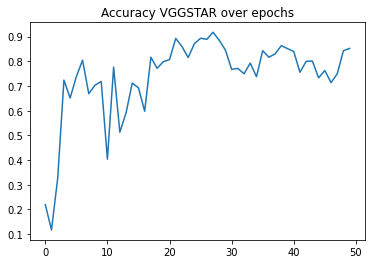

In [ ]:
DO = 'TRAIN'
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=50, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)

Now you can download federated_mnist_best_test.pth